<a href="https://colab.research.google.com/github/pedrohortencio/cancer-detection/blob/main/Breast%20Cancer%20Wisconsin/breast_cancer_Wisconsin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Wisconsin (Diagnostic) Data Set


>Pedro Hortêncio Moreira Rosa <br>
### Universidade Federal de Goiás <br>

### **Inteligência Artificial Aplicada a Saúde** <br>



## Instalação de Bibliotecas

In [ ]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

In [2]:
import sklearn
sklearn.__version__

'0.24.2'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

sns.set_theme(style='white', palette='muted')

seed = 7
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

## Download e Manipulação dos Dados

In [4]:
#Dados do SKLearn, disponibilizados pela UCI ML Repository: https://goo.gl/U2Uwz2
dados_df, labels = load_breast_cancer(return_X_y = True, as_frame=True)

In [5]:
dados_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
labels.value_counts()

1    357
0    212
Name: target, dtype: int64

In [9]:
print(dados_df.shape)
print(labels.shape)

(569, 30)
(569,)


### Estandardização

In [11]:
std_scaler = StandardScaler()

X = std_scaler.fit_transform(dados_df)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

In [14]:
print("Formato conjunto de treino:", X_train.shape)
print("Formato labels de treino:", y_train.shape)
print("Formato conjunto de teste:", X_test.shape)
print("Formato labels de teste:", y_test.shape)

Formato conjunto de treino: (426, 30)
Formato labels de treino: (426,)
Formato conjunto de teste: (143, 30)
Formato labels de teste: (143,)


## Modelo

### Construção

In [169]:
def create_model():
    model = Sequential()

    model.add(Dense(100))
    model.add(ReLU())
    model.add(Dropout(.2))

    model.add(Dense(50))
    model.add(ReLU())
    model.add(Dropout(.1))

    model.add(Dense(30))
    model.add(ReLU())
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer = Adam(learning_rate=0.0005),
              loss = 'binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])
    
    return model

In [200]:
model_keras = KerasClassifier(build_fn=create_model, epochs=20,
                              batch_size=64, verbose=0)

### Cross-Validation

In [201]:
results = cross_val_score(model_keras, X_train, y_train, cv=kfold)
acc_train = results.mean()
print("Acurácia KFold", acc_train)

Acurácia KFold 0.969466483592987


### Treino e Predição do Conjunto de Testes

In [202]:
model_keras.fit(X_train, y_train)

In [203]:
predicted = model_keras.predict(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Avaliação dos Resultados (Conjunto de Teste)

### Acurácia e Relatório de Classificação

In [204]:
acc = accuracy_score(y_test, predicted)
print("Acurácia (Conjunto de testes):", acc)

Acurácia (Conjunto de testes): 0.986013986013986


In [205]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        54
           1       0.99      0.99      0.99        89

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



### ROC AUC (Curva e Score)

In [211]:
print("ROC AUC Score:", roc_auc_score(y_test, predicted))

ROC AUC Score: 0.9851227632126508


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


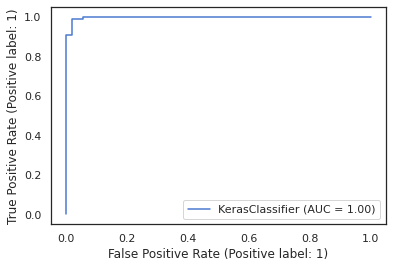

In [210]:
model_keras._estimator_type = "classifier"
plot_roc_curve(model_keras, X_test, y_test);
plt.show();

### Matriz de Confusão

In [217]:
confusion_matrix(y_test, predicted)

array([[53,  1],
       [ 1, 88]])

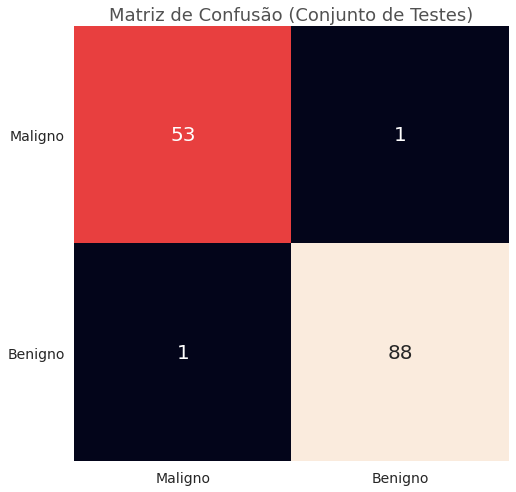

In [216]:
# Criando um DataFrame. O índice e as colunas são os nomes dos batimentos, os valores são os retornados pela matriz de confusão
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted), index = ["Maligno", "Benigno"],
                  columns = ["Maligno", "Benigno"])

# Criando uma figura 8x8
plt.figure(figsize = (8,8))

# Criando um heatmap com base no dataframe criado anteriormente
ax = sns.heatmap(df_cm,
                 annot=True,  # ativa a anotação dos valores dentro dos quadrados
                 fmt='g',   # retira a notação científica dos valores
                 cbar=False,  # retira o cbar da imagem
                 square=True, # plot em forma de quadrados
                 annot_kws={"fontsize":20}) # define o tamanho da fonte dos números

# Define tamanho da fonte dos labels dos eixos x e y
plt.yticks(fontsize=14, rotation=0)
plt.xticks(fontsize=14)

# Adiciona um título
plt.title("Matriz de Confusão (Conjunto de Testes)", size=18, alpha=0.8)

plt.show();